In [63]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import requests
from io import StringIO

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Menyiapkan Dataset

In [3]:
# Membuat DataFrame dari hasil scrapping data
app_reviews_df = pd.read_csv('ulasan_aplikasi_bstation.csv')

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

In [4]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8d6e0c6e-a366-4b00-8d9e-825c9349249b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Dulu suka dengan aplikasi ini tapi sekarang su...,2,4,2.75.1,2024-07-15 03:59:54,Ulasan kamu sudah kami sampaikan kepada tim te...,2024-07-17 10:59:27,2.75.1
1,73e77d31-f361-4310-a173-6637988c2c25,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Ga masalah iklannya, tapi kenyamanan menonton ...",2,2,2.42.1,2024-04-24 01:26:39,Ulasan kamu sudah kami sampaikan kepada tim te...,2024-04-25 11:13:20,2.42.1
2,6954463f-ee3a-4f20-a2eb-bb91d7793fff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi yang bagus,banyak tontonan gratis,tpi...",4,125,3.4.0,2024-09-08 23:19:08,NaN,NaN,3.4.0
3,b6ad5130-6257-4cae-9ffa-042bb75fb12e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,guwe kasih rating 1 karena di aplikasi bstatio...,1,994,3.4.0,2024-09-09 00:56:07,Ulasan kamu sudah kami sampaikan kepada tim te...,2024-05-24 11:07:24,3.4.0
4,6840ddf5-5c0a-44f5-a447-9ba2aa0f0445,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya bagus namun masalah subtitle serin...,4,82,3.4.0,2024-09-04 11:33:28,NaN,NaN,3.4.0


In [5]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              100000 non-null  object
 1   userName              100000 non-null  object
 2   userImage             100000 non-null  object
 3   content               100000 non-null  object
 4   score                 100000 non-null  int64 
 5   thumbsUpCount         100000 non-null  int64 
 6   reviewCreatedVersion  61593 non-null   object
 7   at                    100000 non-null  object
 8   replyContent          16988 non-null   object
 9   repliedAt             16989 non-null   object
 10  appVersion            61593 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.4+ MB


In [6]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11574 entries, 0 to 93268
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11574 non-null  object
 1   userName              11574 non-null  object
 2   userImage             11574 non-null  object
 3   content               11574 non-null  object
 4   score                 11574 non-null  int64 
 5   thumbsUpCount         11574 non-null  int64 
 6   reviewCreatedVersion  11574 non-null  object
 7   at                    11574 non-null  object
 8   replyContent          11574 non-null  object
 9   repliedAt             11574 non-null  object
 10  appVersion            11574 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


# Preprocessing

In [8]:
# tahap pre-processing

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [9]:
# memproses slang words / kata tidak informal
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "byk": "banyak", "blm": "belum", "dlu": "dulu", "skrang": "sekarang", "sy": "saya", "ttp": "tetap", "jg": "juga", "ngk": "tidak", "gk": "tidak", "bgt": "sangat", "bagu": "bagus", "skrng": "sekarang", "bnyk": "banyak", "aj": "saja", "klo": "kalau", "trs": "terus", "eror": "error", "ni": "ini", "ilang": "hilang", "ad": "ada", "vidio": "video", "yg": "yang"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [10]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

# Pelabelan

In [11]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [12]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if score > 0:
        polarity = 'positive'
        # Jika skor sentimen lebih besar dari 0, maka polaritas adalah positif
    elif score < 0:
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    elif score == 0:
        polarity = 'neutral'
        # Jika skor sentimen adalah 0, maka polaritas adalah netral

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [13]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    5492
positive    4401
neutral     1681
Name: count, dtype: int64


# Grafik

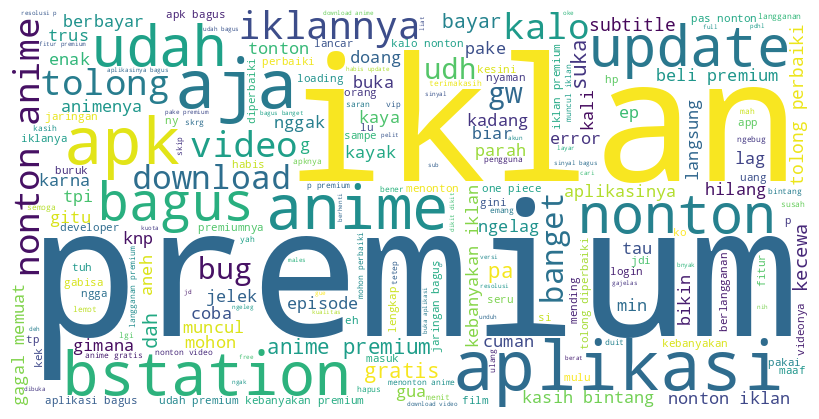

In [14]:
# Gabungkan semua teks dalam column 'teks_akhir' menjadi satu string
text = " ".join(review for review in clean_df['text_akhir'])

# Membuat WordCloud Objek
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Mendisplay WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

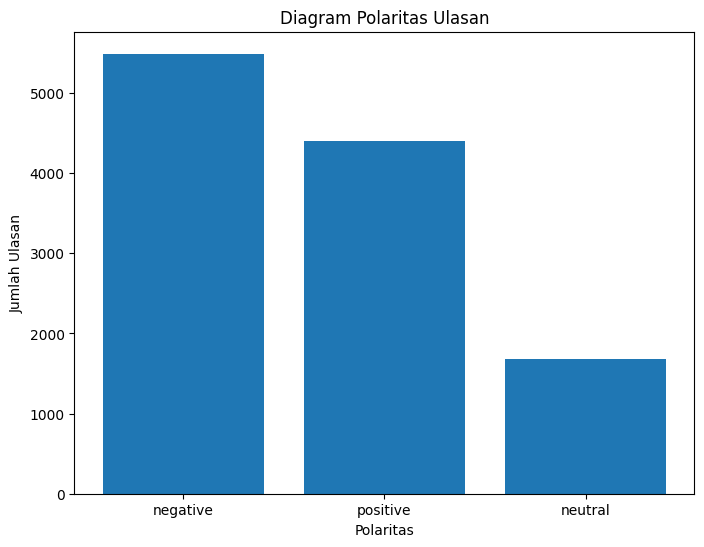

In [15]:
# Menghitung jumlah ulasan untuk setiap kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
plt.bar(polarity_counts.index, polarity_counts.values)
plt.xlabel('Polaritas')
plt.ylabel('Jumlah Ulasan')
plt.title('Diagram Polaritas Ulasan')
plt.show()

# Data Splitting & Ekstraksi Fitur

In [73]:
# Parameter untuk tokenisasi dan padding
max_words = 10000  # Jumlah kata yang akan di tokenisasi
max_len = 100  # Panjang maksimum setiap sequence

# Tokenisasi teks
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(clean_df['text_akhir'])
sequences = tokenizer.texts_to_sequences(clean_df['text_akhir'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating='post')
vocabulary_size = len(tokenizer.word_index) + 1

# Ekstraksi Fitur Menggunakan TF-IDF
X = clean_df['text_akhir']
y = clean_df['polarity']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Modeling

In [74]:
# Fungsi Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\nAkurasi telah mencapai >97%!")
      self.model.stop_training = True
callbacks = myCallback()

In [75]:
# Buat model LSTM
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# Latih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callbacks])

Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - accuracy: 0.5296 - loss: 0.9678 - val_accuracy: 0.7786 - val_loss: 0.5440
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8087 - loss: 0.4816 - val_accuracy: 0.8283 - val_loss: 0.4421
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9066 - loss: 0.2737 - val_accuracy: 0.8461 - val_loss: 0.4145
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9389 - loss: 0.1865 - val_accuracy: 0.8488 - val_loss: 0.4252
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9642 - loss: 0.1221 - val_accuracy: 0.8483 - val_loss: 0.4471
Epoch 6/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9704 - loss: 0.0928
Akurasi telah mencapai >97%!
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9704 - loss: 0.0928 - val_accuracy: 0.8542 - val_loss: 0.4696
